In [1]:
import pathlib, os
if 'TSL_SCHOOL_DIR' in os.environ:
    assert not any( (p/".git").is_dir() for p in (pathlib.Path(".").absolute().resolve()/"dummy").parents ),\
                     'Please copy notebook to a work directory'

## Nuclear data analysis with OpenMC

The `openmc.data` submodule of the Python API provides access to classes that allow to load and inspect nuclear data. You can read more abut in [the documentation](https://docs.openmc.org/en/latest/pythonapi/data.html):

In [2]:
import openmc
import openmc.data
import numpy as np
import matplotlib.pyplot as plt
openmc.config['cross_sections'] = '/home/student/tsl_software/endfb-viii.0-hdf5/cross_sections.xml'
import os
import NCrystal as NC
import pyne
import pyne.endf

/tmp/ipykernel_22598/2928495047.py:9: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  import pyne.endf


The `ThermalScattering()` class provides direct access to thermal scattering kernels in ACE format, or in OpenMC's own HDF5 library:

In [3]:
help(openmc.data.ThermalScattering)

Help on class ThermalScattering in module openmc.data.thermal:

class ThermalScattering(openmc.mixin.EqualityMixin)
 |  ThermalScattering(name, atomic_weight_ratio, energy_max, kTs)
 |  
 |  A ThermalScattering object contains thermal scattering data as represented by
 |  an S(alpha, beta) table.
 |  
 |  Parameters
 |  ----------
 |  name : str
 |      Name of the material using GNDS convention, e.g. c_H_in_H2O
 |  atomic_weight_ratio : float
 |      Atomic mass ratio of the target nuclide.
 |  kTs : Iterable of float
 |      List of temperatures of the target nuclide in the data set.
 |      The temperatures have units of eV.
 |  
 |  Attributes
 |  ----------
 |  atomic_weight_ratio : float
 |      Atomic mass ratio of the target nuclide.
 |  energy_max : float
 |      Maximum energy for thermal scattering data in [eV]
 |  elastic : openmc.data.ThermalScatteringReaction or None
 |      Elastic scattering derived in the coherent or incoherent approximation
 |  inelastic : openmc.data

We can access the data using the `.from_hdf5()` and `.from_ace()` class methods. We will also see how to convert an ENDF file using NJOY to ACE. 

### Importing from HDF5 files

Let's start with by opening the cross sections for hydrogen in light water contained in the OpenMC data library:

In [4]:
data_h5 = openmc.data.ThermalScattering.from_hdf5('/home/student/tsl_software/endfb-viii.0-hdf5/neutron/c_H_in_H2O.h5')

Here we are reading an HDF5 formatted file with a format that is described in the [OpenMC documentation](https://docs.openmc.org/en/stable/io_formats/nuclear_data.html#thermal-neutron-scattering-data), and contains a transcription of the [ACE format](https://raw.githubusercontent.com/NuclearData/ACEFormat/master/ACEFormat.pdf) (see Sect. 6). The file was processed from the [ENDF/B-VIII.0](https://www.nndc.bnl.gov/endf-b8.0/) (see also the associated [paper](https://doi.org/10.1016/j.nds.2018.02.001)) evaluation for hydrogen bound in light water, which was based on the [CAB Model for water](https://doi.org/10.1016/j.anucene.2013.11.014).

Thermal scattering files contain two "nuclear reactions" (the quotes here meaning that although they are the same nuclear reaction, there are separated for practical purposes): thermal `.elastic` and thermal `.inelastic`. Thermal elastic includes the interaction of neutrons with atoms in their average equilibrium positions, with an effective infinite mass and no energy transfer. Thermal inelastic includes the excitation of phonons or other modes in the material. Since light water is a liquid, there are no equilibrium positions for its atoms, and all scattering is inelastic:

In [5]:
print(data_h5.elastic)

None


In [6]:
print(data_h5.inelastic)

The inelastic `ThermalScatteringReaction` contains data in two members: `.xs` and `.distribution`. This follows the ACE format for thermal scattering, where the double differential cross section is formatted as:

$$ \mathrm{d}^2\sigma/\mathrm{E}\mathrm{d} = \sigma(E_i,T)*P_1(E_o | E_i, T)*P_2(\mu | E_o, E_i, T)$$ 

Where $\sigma(E_i,T)$ is the inelastic scattering cross section for a given incident energy $E_i$ and a given temperature $T$, $P_1(E_o | E_i, T)$ is the conditional probability distribution of the neutron emerging with an energy $E_o$ if the incident energy in $E_i$ and the temperature is $T$, and $P_2(\mu | E_o, E_i, T)$ is the probability distribution for the cosine of the scattering angle $\mu$ for fixed $T$, $E_i$ and $E_o$.

The member `.xs` stores $\sigma(E_i)$ as a dictionary for a given $T$.

The member `.distribution` stores $P_1$ and $P_2$ as a dictionary for a given $T$.


In [7]:
print(data_h5.inelastic.xs.keys())

dict_keys(['284K', '294K', '300K', '324K', '350K', '374K', '400K', '424K', '450K', '474K', '500K', '524K', '550K', '574K', '600K', '624K', '650K', '800K'])


Text(0, 0.5, 'XS [b]')

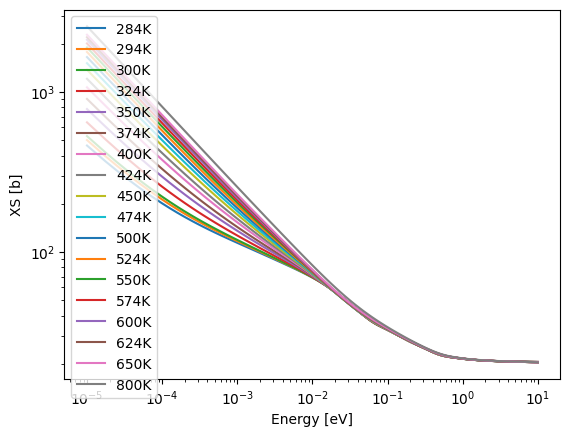

In [8]:
for T, table in data_h5.inelastic.xs.items():
    plt.loglog(table.x, table.y, label=T)
plt.legend()
plt.xlabel('Energy [eV]')
plt.ylabel('XS [b]')

We can pick one of the temperatures and incident energies and see the outgoing energy and angle distributions:

In [9]:
i = 90
print(f"Point {i} corresponds to E_i = {data_h5.inelastic.xs['294K'].x[i]} eV in the cross section table.")
print(f"Point {i} corresponds to E_i = {data_h5.inelastic.distribution['294K'].energy[i]} eV in the energy/angle distribution.")

Point 90 corresponds to E_i = 0.95 eV in the cross section table.
Point 90 corresponds to E_i = 0.95 eV in the energy/angle distribution.


This particular nuclear data file is stored using a continous distribution for outgoing energy (see Sect. 6.3.2 in the [ACE Format manual](https://raw.githubusercontent.com/NuclearData/ACEFormat/master/ACEFormat.pdf). Older files might contain probilities using discrete distributions:

Text(0.5, 1.0, 'Ei = 0.95 eV')

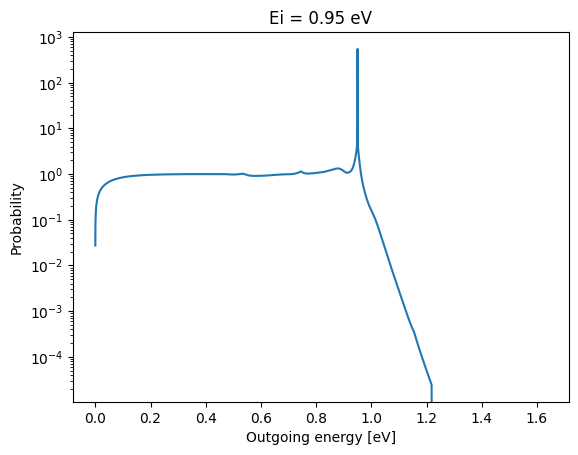

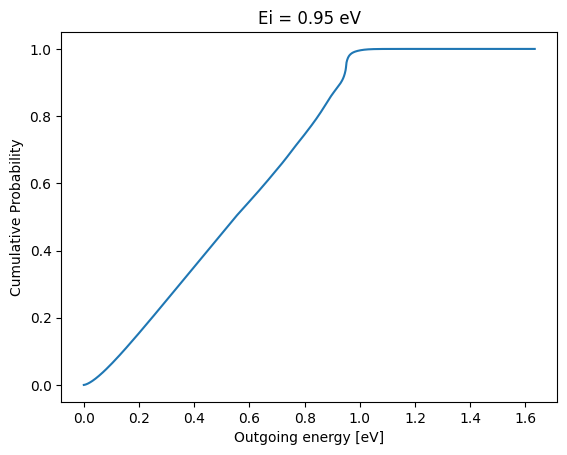

In [10]:
incident_energy = data_h5.inelastic.distribution['294K'].energy[i]
outgoig_energies = data_h5.inelastic.distribution['294K'].energy_out[i].x
outgoing_energy_probabilities = data_h5.inelastic.distribution['294K'].energy_out[i].p
outgoing_energy_cumulative_probabilities = data_h5.inelastic.distribution['294K'].energy_out[i].c
plt.semilogy(outgoig_energies, outgoing_energy_probabilities)
plt.xlabel('Outgoing energy [eV]')
plt.ylabel('Probability')
plt.title(f'Ei = {incident_energy} eV')
plt.figure()
plt.plot(outgoig_energies, outgoing_energy_cumulative_probabilities)
plt.xlabel('Outgoing energy [eV]')
plt.ylabel('Cumulative Probability')
plt.title(f'Ei = {incident_energy} eV')

### Importing from ACE

Let's use now the `from_ace()` class method to compare with a different scattering kernel. The ENDF/B-VI.3 scattering kernels distributed with MCNP in ACE format are available in the [LANL Nuclear Data website](https://nucleardata.lanl.gov/):

In [11]:
!wget https://nucleardata.lanl.gov/lib/sab2002.zip
!unzip -o sab2002.zip

--2023-05-20 16:47:19--  https://nucleardata.lanl.gov/lib/sab2002.zip
Resolving nucleardata.lanl.gov (nucleardata.lanl.gov)... 52.85.242.7, 52.85.242.41, 52.85.242.113, ...
Connecting to nucleardata.lanl.gov (nucleardata.lanl.gov)|52.85.242.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34064372 (32M) [application/x-zip-compressed]
Saving to: ‘sab2002.zip.4’

sab2002.zip.4       100%[===================>]  32,49M  6,12MB/s    in 5,7s    

2023-05-20 16:47:25 (5,66 MB/s) - ‘sab2002.zip.4’ saved [34064372/34064372]

Archive:  sab2002.zip
  inflating: sab2002/.DS_Store       
  inflating: sab2002/._.DS_Store     
  inflating: sab2002/docs/la-11952.pdf  
  inflating: sab2002/docs/la-12639.pdf  
  inflating: sab2002/docs/la-ur-03-808.pdf  
  inflating: sab2002/docs/table_g1.pdf  
  inflating: sab2002/README.md       
  inflating: sab2002/sab2002/sab2002  
  inflating: sab2002/xsdir           


This file contains several scattering kernels, for different materials at different temperatures. In particular, the scattering kernels for light water are called  "lwtr.60t" to "lwtr.64t":

In [12]:
!cat sab2002/xsdir | grep lwtr

lwtr.60t 0.999170 sab2002/sab2002 0 1 439861 63221 0 0 2.530100E-08
lwtr.61t 0.999170 sab2002/sab2002 0 1 455679 63221 0 0 3.447000E-08
lwtr.62t 0.999170 sab2002/sab2002 0 1 471497 63221 0 0 5.170400E-08
lwtr.63t 0.999170 sab2002/sab2002 0 1 487315 63221 0 0 6.893900E-08
lwtr.64t 0.999170 sab2002/sab2002 0 1 503133 63221 0 0 8.617400E-08


Since this file contains more than one ACE table, we need to open it using the `openmc.data.Library()` class:

In [13]:
temp = openmc.data.Library('sab2002/sab2002/sab2002', table_names='lwtr.60t').tables[0]
data_ace = openmc.data.ThermalScattering.from_ace(temp)

This file contains data for light water at room temperature:

In [14]:
data_ace.temperatures

['294K']

We can compare this with the cross section accessed above:

Text(0, 0.5, 'XS [b]')

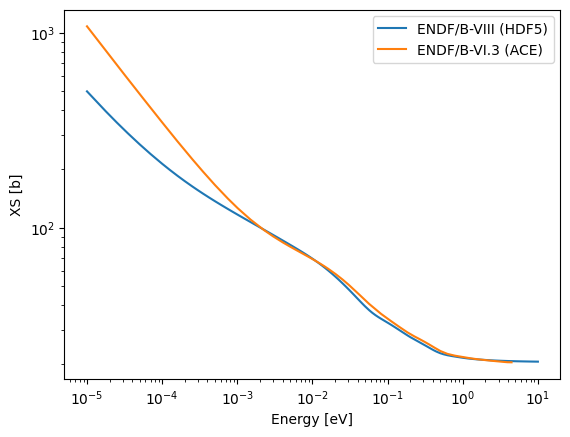

In [15]:
plt.loglog(data_h5.inelastic.xs['294K'].x,data_h5.inelastic.xs['294K'].y, label='ENDF/B-VIII (HDF5)')
plt.loglog(data_ace.inelastic.xs['294K'].x,data_ace.inelastic.xs['294K'].y, label='ENDF/B-VI.3 (ACE)')
plt.legend()
plt.xlabel('Energy [eV]')
plt.ylabel('XS [b]')

This file is an older ACE format, and the outgoing energy distribution is discrete, and the `energy_out` object is just a numpy array containing the outgoing energies:

In [16]:
i = 42
Ei = data_ace.inelastic.xs['294K'].x[i]
print(f"Point {i} corresponds to E_i = {Ei} eV in the cross section table.")
print(type(data_ace.inelastic.distribution['294K'].energy_out[i]))

Point 42 corresponds to E_i = 0.9506956 eV in the cross section table.
<class 'numpy.ndarray'>


Each of these points have assigned a probability. If the `skewed` probability is set, the border points have lower probability. Otherwise, all outgoing energies are equiprobable:

In [17]:
data_ace.inelastic.distribution['294K'].skewed

True

In [18]:
Ef = data_ace.inelastic.distribution['294K'].energy_out[i]
p = np.ones(len(Ef))
if data_ace.inelastic.distribution['294K'].skewed:
    p[0] = .1
    p[1] = .4
    p[-2] = .4
    p[-1] = .1
p = p/sum(p)

If we plot these values we can see there are more points near $E_i$, corresponding to the quasielastic scattering peak:

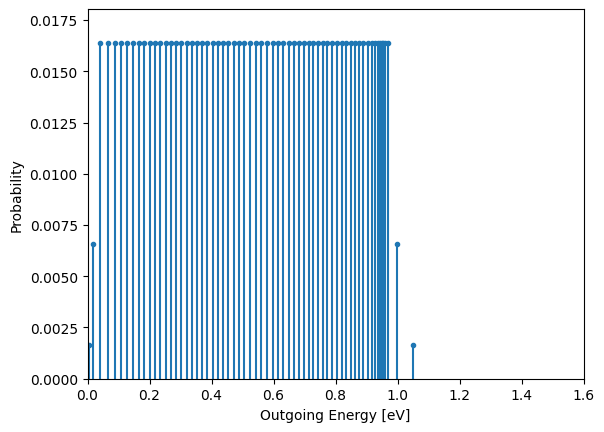

In [19]:
plt.plot(Ef, p, '.', label=f'Ei = {Ei:.2e} eV')
plt.vlines(Ef, 0, p)
plt.xlabel('Outgoing Energy [eV]')
plt.ylabel('Probability')
plt.xlim(0, 1.6)
plt.ylim(0, 1.1*max((p)))
linewidth_value=0.5
marker_size_value=2

At first sight this distribution looks very different from the one plotted above. But, if we find the cumulative sum of the array we can compare with the cumulative continuous distribution:

(0.0, 1.6)

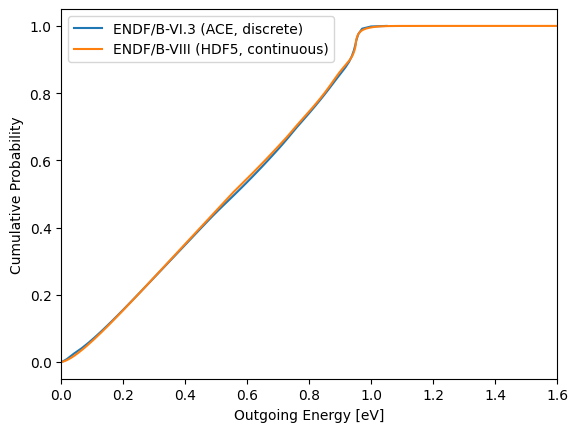

In [20]:
c = np.cumsum(p)
plt.plot(Ef, c, label='ENDF/B-VI.3 (ACE, discrete)')
plt.plot(outgoig_energies, outgoing_energy_cumulative_probabilities, label='ENDF/B-VIII (HDF5, continuous)')
plt.xlabel('Outgoing Energy [eV]')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.xlim(0, 1.6)

### Importing from ENDF-6 files using NJOY

We will get TSL evaluation for the light water from [JEFF 3.3](https://www.oecd-nea.org/dbdata/jeff/jeff33/index.html).We will retrieve the TSL ENDF file from the [IAEA Nuclear Data Section archive](https://www-nds.iaea.org/public/download-endf):

In [21]:
url = 'https://www-nds.iaea.org/public/download-endf/JEFF-3.3/tsl/tsl_0001_H(H2O).zip'
user_agent = '--user-agent="Mozilla/5.0 (X11; Fedora; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0"'
zipfile = 'file.zip'
file = url.split('/')[-1].replace('zip', 'dat')
cleanfile = file.replace('(','_').replace(')','_')
acefile = cleanfile.replace('dat', 'ace')

os.system(f'wget --quiet -O {zipfile} {user_agent} "{url}"')
os.system(f'unzip -o {zipfile}')
if file != cleanfile:
    os.system(f'mv "{file}" "{cleanfile}"')
print(f'Created {cleanfile}')

Archive:  file.zip
  inflating: tsl_0001_H(H2O).dat     
Created tsl_0001_H_H2O_.dat


We will also need the associated neutron sublibrary evaluation. In this case, for H-1.

In [22]:
url = 'https://www-nds.iaea.org/public/download-endf/JEFF-3.3/n/n_0125_1-H-1.zip'
user_agent = '--user-agent="Mozilla/5.0 (X11; Fedora; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0"'
zipfile = 'file.zip'
endffile = url.split('/')[-1].replace('zip', 'dat')

os.system(f'wget --quiet -O {zipfile} {user_agent} "{url}"')
os.system(f'unzip -o {zipfile}')

Archive:  file.zip
  inflating: n_0125_1-H-1.dat        


0

We will open the files with [PyNE](https://pyne.io/) to obtain some of the parameters needed for the processing:

In [23]:
tsl_endf = pyne.endf.Evaluation(cleanfile)
tsl_endf.read()

endf = pyne.endf.Evaluation(endffile)

Reading MF=1, MT=451 Descriptive Data
Reading MF=7, MT=4 (z,n)
Reading MF=1, MT=451 Descriptive Data


In [24]:
tsl_mat = tsl_endf.material
endf_mat = endf.material

temperature = 293.6
assert temperature in tsl_endf.thermal_inelastic['temperature'], 'Temperature not available in the ENDF-6 file'

proc_mat = 237
ielas = 0
proc_mat_elas = 0
if tsl_endf.thermal_elastic != {}:
    proc_mat_elas = proc_mat + 1    
    if tsl_endf.thermal_elastic['type'] == 'incoherent':
        ielas = 1

The following parameters are more difficult to guess, and we will provide explicitly: the ZAIDs to which the TSL library will be assiged, the number of atoms in the TSL inelastic file, and the name that will be given to the TSL ACE material:

In [25]:
zaids = '1001 0 0'
natom = 2
ace_name = 'hh2o'

print('Scattering XS is {} b'.format(tsl_endf.thermal_inelastic['B'][0]/natom))

Scattering XS is 20.43634 b


We need to check that the above value corresponds to the free gas limit of the scattering nuclide. We can compare with the values from the NCrystal library:

In [26]:
nuclide = 'H1'
print(f"The free atom scattering XS for f{nuclide} is {NC.atomDB('H1').freeScatteringXS()} b in the NCrystal AtomDB.")

The free atom scattering XS for fH1 is 20.48999526773148 b in the NCrystal AtomDB.


We will now create an NJOY input file with these parameters. We will use the modules `MODER`, `RECONR` and `BROADER` to process the neutron data for H1, and `THERMR` and `ACER` to process the light water thermal scattering evaluation and produce the ACE file. For more details on the syntaxis please read the [NJOY 2016 manual](https://github.com/njoy/NJOY2016-manual/raw/master/njoy16.pdf):

In [27]:
txt = f"""
moder
20 -21 /
reconr 
-21 -22
'temp'/
{endf_mat} 1/
0.001 0. 0 /
'temp'/
0/
broadr
-21 -22 -23
 {endf_mat} 1 / 0  0 /
.001/
{temperature} /
0/
thermr
24 -23 -25 /
{tsl_mat} {endf_mat} 16 1 2 1 0 {natom} {proc_mat}  1 /
{temperature} /
0.005 10.0 /
acer
-21 -25 0 30 31
2  1  1  .80  0 /
'Temp'/
{endf_mat} {temperature} {ace_name} /
{zaids} /
237 100 {proc_mat_elas} {ielas} 1 1.0 2 /
stop
"""
with open('input', mode='w') as f:
    f.write(txt)

And run NJOY to generate the ACE file:

In [28]:
os.system(f'cp {endffile} tape20')
os.system(f'cp {cleanfile} tape24')
os.system(f'njoy < input')
os.system(f'cp tape30 {acefile}')


 njoy 2016.62  09Mar21                                       05/20/23 16:47:33
 *****************************************************************************

 moder...                                                                 0.0s

 reconr...                                                                0.0s

 broadr...                                                                0.0s

 thermr...                                                                0.1s

 ***warning***sab contains numbers that are too small to represent on this machine.
 results may be bad for transfers larger than   11.132 ev.

 ***warning***maximum value of beta limits the allowed energy transfer
 the sct approx. will be used for transfers larger than  4.000 ev.

 ---message from thermr---Material is a coherent scatterer. Set ielas=0 in ACER

 wrote thermal data for temp = 2.9360E+02                                 8.2s

 acer...                                                                  8.

0

This file can now be imported into OpenMC to plot and compare with the other evaluations:

In [29]:
data_endf = openmc.data.ThermalScattering.from_ace(acefile)

Text(0, 0.5, 'XS [b]')

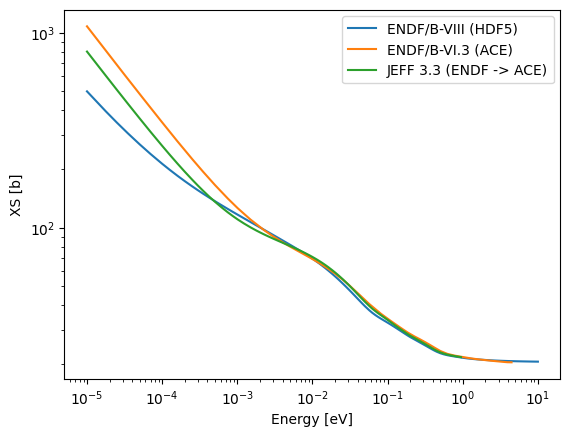

In [30]:
plt.loglog(data_h5.inelastic.xs['294K'].x,data_h5.inelastic.xs['294K'].y, label='ENDF/B-VIII (HDF5)')
plt.loglog(data_ace.inelastic.xs['294K'].x,data_ace.inelastic.xs['294K'].y, label='ENDF/B-VI.3 (ACE)')
plt.loglog(data_endf.inelastic.xs['294K'].x,data_endf.inelastic.xs['294K'].y, label='JEFF 3.3 (ENDF -> ACE)')
plt.legend()
plt.xlabel('Energy [eV]')
plt.ylabel('XS [b]')

The class `openmc.data.ThermalScattering` also contains a `from_njoy()` class method which automates this process, but it only works for materials for which it can safely estimate the input parameters.